In [2]:
"""
Author: Hamidani
Date: 19/04/2025

Model based on Hamidani & Ioka (2021, 2023a, 2023b, 2024a, 2025a, 2025b).

This code uses the parameters of:
- Jet: energy (E_eng), engine timescale (t_eng), opening angle (theta_0)
- Ambient medium: radius (R_a), mass (M_a), density profile (n = 2 by default)

It calculates:
1. Jet propgation through the ambient medium
2. The cooling emission from the cocoon 
It outputs flux for different observer times and frequency bands.

Notes:
1. Default values are for EP250108a.
2. Jet/CSM parameters are based on GRB060218 due to its similarity to EP250108a.
3. To speed up the run, adjust `n1` and `n2` (time grid), and the `nu_values` array (frequencies).
4. The main paramters are: 
E_eng (jet total energy)
M_a (CSM mass)
R_a (CSM radius)
opacity (thomson scattering opacity)
"""



import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from astropy.constants import c, h, k_B, sigma_sb, M_sun, R_sun
from astropy import units as u


# Basic constants to CGS units
c = c.cgs.value               # Speed of light [cm/s]
h = h.cgs.value               # Planck constant [erg·s]
k_B = k_B.cgs.value           # Boltzmann constant [erg/K]
sigma = sigma_sb.cgs.value   # Stefan–Boltzmann constant [erg/cm^2/s/K^4]
M_sun = M_sun.cgs.value       # Solar mass [g]
R_sun = R_sun.cgs.value       # Solar radius [cm]
pi = np.pi  # Pi
day = 3600*24 # 1day in seconds
Mpc = 3.0857e24 #1 Mpc in cm


########################
### Model paramteres ###
########################

# A. Variable model parameters
def get_default_params():
    return {
        'E_eng': 1e51,      # Jet energy [erg]
        'M_a': 0.1,         # Ambient mass [Msun]
        'R_a': 1e13,        # Radius of ambient medium [cm]
        'kappa': 0.1,       # Opacity [cm^2/g] (Thomson scattering)
    }

# B. Fixed model parameters

# EP250108a: redshift and distance
z   = 0.17641  
d_L = 880.6*Mpc


# Ambient medium (e.g. CSM around the GRB progenitor)
n = 2             # Density profile slope
R_0 = 4e10        # [cm] Inner radius of ambient medium

# Jet parameters
t_eng = 100                # [s] Engine activity timescale (~free-fall~100s timescale; Matzner 2003)
theta_0 = 10. * pi / 180.  # [rad] Opening angle (~10deg)
Ns = 0.5                   # Jet-head calibration coefficient (~0.5; Hamidani & Ioka 2021; simultions in Suzuki+ 2024)
Gamma_j = 100              # Lorentz factor of the unshocked jet (~100; from compactness problem)
beta_j = 1                 # Velocity of the unshocked jet in c

# Other propagation coefficients
chi = 1.          # Static case (Hamidani & Ioka 21)
eta = 1.          # Static case (Hamidani & Ioka 21)
c0  = 0.658577    # Jet-head parameter (Hamidani+25a)
b   = 0.787993    # Jet-head parameter (Hamidani+25a)

# Post-breakout parameters
fmix = 0.5  # mixing paramter between the inner cocoon (rela.) and the outer cocoon (n. rela.)
#1 fully mixed 
#0 no mixing
s = 1.01 # index for internal energy distribution (=1 for dE/d(log{Gammabeta}))~const.
m = 5.01 # index for density profile of the outer cocoon (from energy conservation; see Eisenberg+2022; Suzuki+2022)

# Photons diffusion paramters
d_f1 = 1   # with tau*d_f1 =c/v
# = 1: tau = c/v   Classical
# = 3: tau = c/v/3 Piro+2021
d_f2 = 0   # setting of diffusion criterion
# = 0: tau=c/v [no thickness; Nakar & Piran 2017]
# = 1: tau=c/(vmax - v) [thickness; Kisaka+ 2015; Hamidani & Ioka 2023]
tau_ph = 1 # photospheric optical depth
L_decay = 0 # setting for the luminosity decay
# = 0: exp decay as in Piro+2021  
# = 1: exp*power-law as in Hamidani+25b 


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Comment: Reduce bands to make it faster
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Output bands
# Frequencies in Hz
nu_values = np.array([
    6.00e9,     #0 : 6 GHz
    1.37e14,    #1 : K
    1.84e14,    #2 : H
    2.46e14,    #3 : J
    3.29e14,    #4 : z
    3.79e14,    #5 : i
    4.47e14,    #6 : r
    6.83e14,    #7 : b
    8.65e14,    #8 : u
    1.15e15,    #9 : W1
    1.33e15,    #10: M2
    1.55e15,    #11: W2
    2.42e17     #12: 1 keV
])

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Comment: Adjust the time grid to make it faster (if need be)
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Time grid number (n1+n2)
# data points in the optically thick phase
n1 = 20
# data points in the optically thin phase
n2 = 10

####################
### Jet Dynamics ###
####################

# function to get jet head velocity
def function_betah(C):
    # Model paramters => C => betah
    # Hamidani+2025a
    small_C_approx = C**(1/3)
    large_C_approx = 1 - C**(-1/5)
    transition_factor = 1 / (1 + (C / c0)**b)
    return transition_factor * small_C_approx + (1 - transition_factor) * large_C_approx

# function to get jet dynamics up to the breakout
def function_breakout(params):
    # Hamidani+25a jet dynamics up to the breakout
    # params => C => betah => betap => breakout time...
    M_a_cgs = params['M_a'] * M_sun

    # Jet/medium parameter
    C = (2**6 * eta * Ns**4 * params['E_eng'] * params['R_a']) / (c**3 * t_eng * theta_0**4 * M_a_cgs)

    # jet head velocity
    betah = function_betah(C)

    # cocoon sideway expansion
    betap = (eta * params['E_eng'] * params['R_a'] * betah * (1 - betah) / (4 * t_eng * M_a_cgs * c**3))**0.25
    betap = np.minimum(betap, betah)

    # breakout time
    t_b = (params['R_a'] - R_0) / (c * betah)  # [s]

    # timescale of the residual jet
    t_jet = t_eng - t_b * (1. - betah)
    t_jet = np.maximum(t_jet, 0)
    
    return betah, betap, t_b, t_jet


#######################
### Cocoon Dynamics ###
#######################

# pre breakout cocoon dynamics
def function_cocoon_pre_tb(params):
    # jet dynamics
    betah, betap, t_b, t_jet = function_breakout(params)
    
    # paramters
    E_eng = params['E_eng']
    R_a   = params['R_a']
    M_a   = params['M_a']
    
    
    # jet energy
    Ej = E_eng*t_jet/t_eng
    # cocoon energy
    Ec = E_eng - Ej
    # volume fraction of the cocoon [assuming ellipsoidal shape; Hamidani & Ioka 2021]
    fv = (betap/betah)**2
    # mass fraction of the cocoon [Hamidani & Ioka 2023a]
    fm = 2*(np.log(R_a/R_0)-1.)*fv
    fm = np.minimum(fm,1)
    # cocoon mass at t_b
    Mc_i= M_a*fm
    # asymptotic cocoon mass
    Mc_f= M_a
    
    # typical cocoon velocity [Eisenberg+22]
    Gamma_t = 1 + Ec/(Mc_i*M_sun*c**2)
    beta_t  = np.sqrt(1.-1./Gamma_t**2)

    # inner cocoon velocity [Eisenberg+22]
    if fm < 1:        
        beta_in = np.sqrt(Ec/(Mc_f*M_sun*c**2))
    else:
        beta_in = beta_t*np.sqrt(1-fmix)
    
    # outer cocooon velocity [energy/mass conversation]
    beta_out = beta_t*beta_t/beta_in

    # mean proper velocity of the jet-cocoon system
    av_u4 = 10**(np.log10(Gamma_t*beta_t)*Ec/E_eng + np.log10(Gamma_j*beta_j)*Ej/E_eng)
     
    return Ej,Ec,Mc_i,Mc_f,beta_in,beta_t,beta_out,av_u4

# post breakout cocoon dynamics
def function_cocoon_post_tb(params):
    # import pre breakout cocoon data
    Ej,Ec,Mc_i,Mc_f,beta_in,beta_t,beta_out,av_u4 = function_cocoon_pre_tb(params)
    # jet dynamics
    betah, betap, t_b, t_jet = function_breakout(params)

    
    # identify the jet regime:
    # successful/barely failed/failed
    if t_jet > 0:
        # Successful
        # inner cocoon (Rela): yes
        # outer cocoon (Non-Rela): yes
        beta_out = beta_t
        Ec_nr = Ec*(1-fmix)
        Ec_r  = Ec*fmix

    elif av_u4 >= 0.5 and t_jet == 0:
        # Barely failed
        # inner cocoon (Rela): yes
        # outer cocoon (Non-Rela): yes
        beta_out = beta_t
        Ec_nr = Ec*(1-fmix)
        Ec_r  = Ec*fmix

    elif av_u4 < 0.5 and t_jet == 0:
        # Completely failed
        # inner cocoon (Rela): no
        # outer cocoon (Non-Rela): yes
        beta_out = beta_t**2 / beta_in
        Ec_nr = Ec
        Ec_r  = 0
    
    # sanity check
    Ek = 0.5*c**2*Mc_f*M_sun*(m-3.)/(m-5.)*(beta_out**(5-m)-beta_in**(5-m))/(beta_out**(3-m)-beta_in**(3-m))
    check = Ek/Ec_nr
    
    return Ec_nr,Ec_r,beta_in,beta_out,check


###############################
### Cocoon Cooling Emission ###
###############################

# fucntion to calcualte the cocoon bolometeric emission
def compute_nonrel_cocoon_cooling(params, z, m, s, d_f1, d_f2, tau_ph):
    from numpy import logspace, log10, sqrt, maximum, minimum, pi
    import numpy as np

    # Get breakout and cocoon data
    betah, betap, t_b, t_jet = function_breakout(params)
    Ec_nr, Ec_r, beta_in, beta_out, check = function_cocoon_post_tb(params)
    
    # grid for time evolution as a function of the diffusion velocity
    N1 = n1
    N2 = n2
    start = 0.9
    time_factor = 1.1**(20/N2)

    # Optically thick phase: beta_d = beta_out ~ beta_in
    beta_d_log = np.logspace(np.log10(beta_out * start), np.log10(beta_in), N1)

    # Optically thin phase: beta_d = beta_in
    beta_d_extra = np.full(N2, beta_in)

    # Array for beta_d
    beta_d_values = np.concatenate([beta_d_log, beta_d_extra])

    # Compute tau_diff (optical depth)
    tau_diff_values = (
        (1 / d_f1)
        * 1 / (
            beta_out * d_f2 
            + (d_f2 + 1) * (1 - d_f2) * beta_d_values 
            - d_f2 * beta_d_values
        )
    )

    # Extract params
    M_a = params['M_a']
    kappa = params['kappa']
    R_a = params['R_a']

    # Time Array
    time_values = sqrt(
        (kappa * M_a * M_sun * (3. - m) / (m - 1.)) 
        / (4. * pi * c**2 * (beta_out**(3 - m) - beta_in**(3 - m))) 
        * ((1. / tau_diff_values) * (beta_d_values**(1 - m) - beta_out**(1 - m)))
    )
    
    # Time for the nebular phase
    for i in range(N1, N1 + N2):
        time_values[i] = time_values[i-1] * time_factor

    

    # Photospheric velocity
    factor_ph = (
        (kappa * M_a * M_sun * (3. - m) / (m - 1.)) 
        / (4. * pi * c**2 * (beta_out**(3 - m) - beta_in**(3 - m))) 
        * 1. / tau_ph 
    )
    beta_ph_values = (time_values**2 / factor_ph + beta_out**(1 - m))**(1 / (1 - m))
    beta_ph_values = minimum(maximum(beta_ph_values, beta_in), beta_out)
    
    # Photospheric radius
    Rph_values = c * maximum(0, (time_values - t_b)) * beta_ph_values + R_a

    # Internal energy distribution
    Ei_tot_values = Ec_nr * R_a / (c * beta_out * maximum(0, (time_values - t_b)) + R_a)
    Ei_d_values   = Ei_tot_values * (beta_out**(1 - s) - beta_d_values**(1 - s)) / (beta_out**(1 - s) - beta_in**(1 - s))

    # Bolometric luminosity (Hamidani & Ioka 2023a)
    # Optically thick phase
    Lbol_values = (
        Ei_d_values / time_values
        * (2. * (1 - s) * beta_d_values**(-s)) / (beta_out**(1 - s) - beta_d_values**(1 - s))
        / ((m - 1) * beta_d_values**(-m) / (beta_d_values**(1 - m) - beta_out**(1 - m)) + 1 / (beta_out - beta_d_values))
    )
    # Optically thin phase
    for i in range(N1, N1 + N2):
        if L_decay == 0:
            # exp decay (Piro+2021)
            Lbol_values[i] = Lbol_values[N1-1] * np.exp(-0.5*((time_values[i]/time_values[N1-1])**2-1))
        elif L_decay == 1:
            # Power-law*exp decay (Hamidani+25b)
            Lbol_values[i] = Lbol_values[i] * np.exp(-0.5*((time_values[i]/time_values[N1-1])**2-1))
        else:
            print("Error: Set L_decay")

    # Temperature (stefan boltzman equation)
    T_values = (Lbol_values / (4. * pi * sigma * Rph_values**2))**0.25

    # Observed time (in days)
    tobs_days_values = time_values * (1 + z) / day

    return {
        "tobs_days": tobs_days_values,
        "Lbol": Lbol_values,
        "T": T_values,
        "Rph": Rph_values,
        "beta_d": beta_d_values,
        "time": time_values,
        "Ei_d": Ei_d_values,
        "beta_ph": beta_ph_values
    }



####################
### Flux Density ###
####################

def compute_band_fluxes(output, nu_values, z, d_L):
    """
    Compute flux densities in observational bands.

    Parameters:
    - output: dict from compute_nonrel_cocoon_cooling()
    - nu_values: array of observed-frame frequencies [Hz]
    - z: redshift
    - d_L: luminosity distance [cm]

    Returns:
    - tobs_days: time array [days]
    - flux_nu: 2D array [len(t) x len(nu)] of flux density [erg/s/cm^2/Hz]
    """
    # Import bolometric data
    T         = output["T"]              # temperature [K]
    Rph       = output["Rph"]            # photospheric radius [cm]
    tobs_days = output["tobs_days"]      # obsever time [day]

    # array for flux as time * freq
    flux_nu = np.zeros((len(tobs_days), len(nu_values)))
    
    # convert observed frequencies to source frame
    nu_values_source = nu_values * (1 + z)  
    
    # calculate blackbody flux
    for i, t in enumerate(tobs_days):
        for j, nu_src in enumerate(nu_values_source):
            # Planck function [erg/s/cm^2/Hz/sr] at source-frame frequency
            B_nu = (2 * h * nu_src**3 / c**2) / (np.exp(h * nu_src / (k_B * T[i])) - 1)
            # Observed flux [erg/s/cm^2/Hz]
            flux = (Rph[i]**2 / d_L**2) * pi * B_nu * (1 + z)
            flux_nu[i, j] = flux

    return tobs_days, flux_nu

In [3]:
#######################
### Activation Cell ###
#######################

# Set model parameters
params = get_default_params()

# Run cocoon model
output = compute_nonrel_cocoon_cooling(params, z, m, s, d_f1, d_f2, tau_ph)

# Extract quantities
tobs   = output["tobs_days"]
Lbol   = output["Lbol"]
T      = output["T"]
Rph    = output["Rph"]
beta_d = output["beta_d"]
beta_ph=output["beta_ph"]

# Compute flux densities
tobs_days, fluxes = compute_band_fluxes(output, nu_values, z, d_L)

/var/folders/r2/wms030zn31vf_1yy8p0rvtww0000gp/T/ipykernel_99490/1479627118.py:404: RuntimeWarning: overflow encountered in exp
  B_nu = (2 * h * nu_src**3 / c**2) / (np.exp(h * nu_src / (k_B * T[i])) - 1)


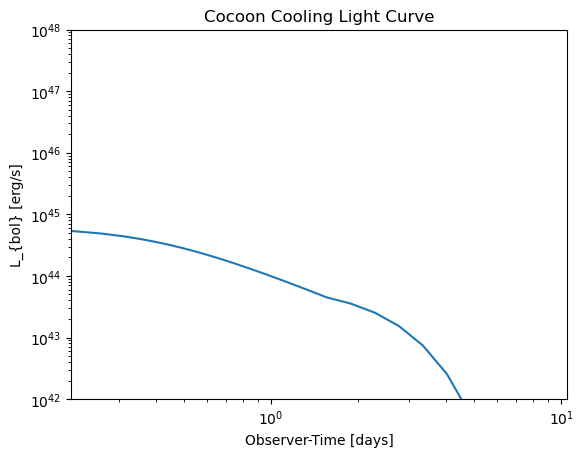

In [4]:
#######################
### Plot Luminosity ###
#######################

plt.plot(tobs, Lbol)
plt.xlabel("Observer-Time [days]")
plt.ylabel("L_{bol} [erg/s]")
plt.xscale("log")
plt.yscale("log")
plt.title("Cocoon Cooling Light Curve")

tmax = tobs.max()
tmin = tobs.min()

plt.xlim(tmin, tmax)  # Set x-axis range
plt.ylim(1e42, 1e48)  # Set y-axis range
plt.show()

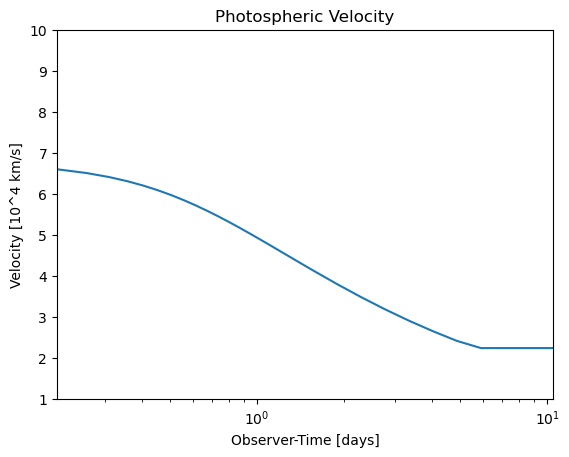

In [5]:
####################
### Plot beta_ph ###
####################
#print(beta_ph*c/1e5/1e4)
plt.plot(tobs, beta_ph*c/1e5/1e4)
plt.xlabel("Observer-Time [days]")
plt.ylabel("Velocity [10^4 km/s]")
plt.xscale("log")
plt.yscale("linear")
plt.title("Photospheric Velocity")

tmax = tobs.max()
tmin = tobs.min()

plt.xlim(tmin, tmax)  # Set x-axis range
plt.ylim(1, 10)  # Set y-axis range
plt.show()

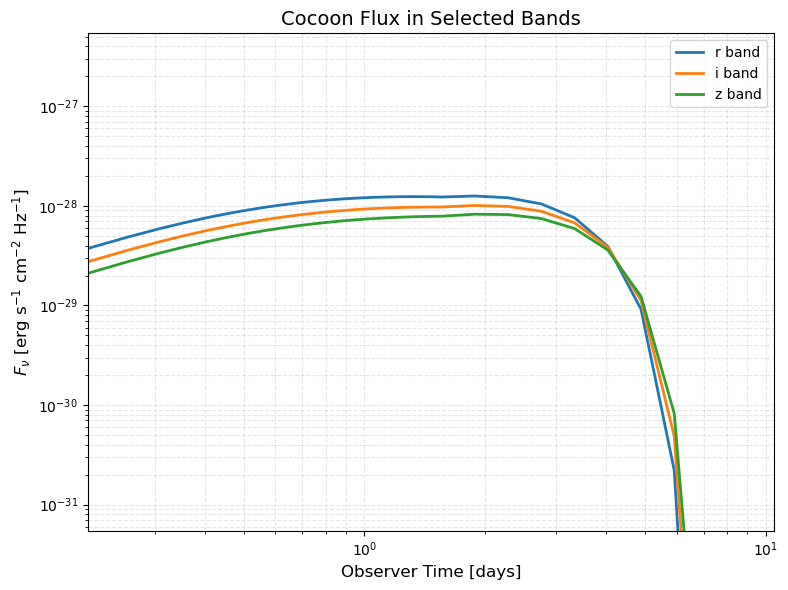

In [6]:
############################
### Plot (r, i, z) bands ###
############################

# Indices for bands: r=6, i=5, z=4
selected_indices = [6, 5, 4]
selected_labels = ['r', 'i', 'z']

plt.figure(figsize=(8, 6))

for i, label in zip(selected_indices, selected_labels):
    plt.plot(tobs_days, fluxes[:, i], label=f'{label} band', lw=2)

# plot setting
plt.xlabel('Observer Time [days]', fontsize=12)
plt.ylabel(r'$F_\nu$ [erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$]', fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.title("Cocoon Flux in Selected Bands", fontsize=14)
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.tight_layout()

plt.xlim(tmin, tmax)
positive_flux = fluxes[fluxes > 0]
if positive_flux.size > 0:
    ymax = positive_flux.max() * 10
    ymin = ymax / 1e5
    plt.ylim(ymin, ymax)


# Optional: save figure
#fig.savefig("flux_cocoon.png", dpi=300, bbox_inches='tight')

plt.show()